### Manipulator Inverse Dynamics (ID)

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from mujoco_py import functions
from mujoco_parser import MuJoCoParserClass
from util import get_colors
print ("Done.")

Done.


### Simulate spring-like behavior 

In [2]:
env = MuJoCoParserClass(name='Panda',rel_path='../asset/panda/franka_panda.xml',VERBOSE=False)
env.init_viewer(TERMINATE_GLFW=True,window_width=0.5,window_height=0.75,cam_distance=3.0,cam_elevation=-45)
env.set_max_sec(max_sec=10.0)

# Set initial manipulator position 
q_rev_des = np.array([0,0,0,-90,0,90,0])*np.pi/180.0 # desired position
env.forward(q_rev=q_rev_des + 30.0*np.random.randn(env.n_rev_joint)*np.pi/180.0) # perturbation

# Buffers
sec_list = np.zeros(env.max_tick)
q_list   = np.zeros((env.max_tick,env.n_rev_joint))
while env.IS_ALIVE():    
    
    # Backup
    qpos_bu = env.sim.data.qpos[env.rev_joint_idxs].copy()
    qvel_bu = env.sim.data.qvel[env.rev_joint_idxs].copy()
    qacc_bu = env.sim.data.qacc[env.rev_joint_idxs].copy()
    
    # Emulate spring
    q_rev = env.get_q_rev()
    q_err = q_rev_des-q_rev
    env.sim.data.qpos[env.rev_joint_idxs] = q_rev
    env.sim.data.qvel[env.rev_joint_idxs] = np.zeros(env.n_rev_joint)
    env.sim.data.qacc[env.rev_joint_idxs] = 20.0*q_err
    functions.mj_inverse(env.sim.model,env.sim.data)
    torque = env.sim.data.qfrc_inverse[env.rev_joint_idxs].copy()
    
    # Restore
    env.sim.data.qpos[env.rev_joint_idxs] = qpos_bu
    env.sim.data.qvel[env.rev_joint_idxs] = qvel_bu
    env.sim.data.qacc[env.rev_joint_idxs] = qacc_bu
    
    # Step
    env.step_and_render(torque=1.0*torque,render_speedup=1.0,RENDER_ALWAYS=False)
    env.print(print_every_sec=1.0,VERBOSE=1)
    # Append
    sec_list[env.tick-1] = env.get_sec_sim()
    q_list[env.tick-1,:] = env.get_q_rev()
print ("Done.")

Creating window glfw
tick:[501/5001], sec_wall:[0.908]sec, sec_sim:[1.000]sec
tick:[1001/5001], sec_wall:[1.777]sec, sec_sim:[2.000]sec
tick:[1501/5001], sec_wall:[2.807]sec, sec_sim:[3.000]sec
tick:[2001/5001], sec_wall:[3.841]sec, sec_sim:[4.000]sec
tick:[2501/5001], sec_wall:[4.882]sec, sec_sim:[5.000]sec
tick:[3001/5001], sec_wall:[5.917]sec, sec_sim:[6.000]sec
tick:[3501/5001], sec_wall:[6.955]sec, sec_sim:[7.000]sec
tick:[4001/5001], sec_wall:[7.995]sec, sec_sim:[8.000]sec
tick:[4501/5001], sec_wall:[8.981]sec, sec_sim:[9.000]sec
tick:[5001/5001], sec_wall:[9.992]sec, sec_sim:[10.000]sec
Done.


In [3]:
env.terminate_viewer() # terminate viewer

### Plot joint trajectories

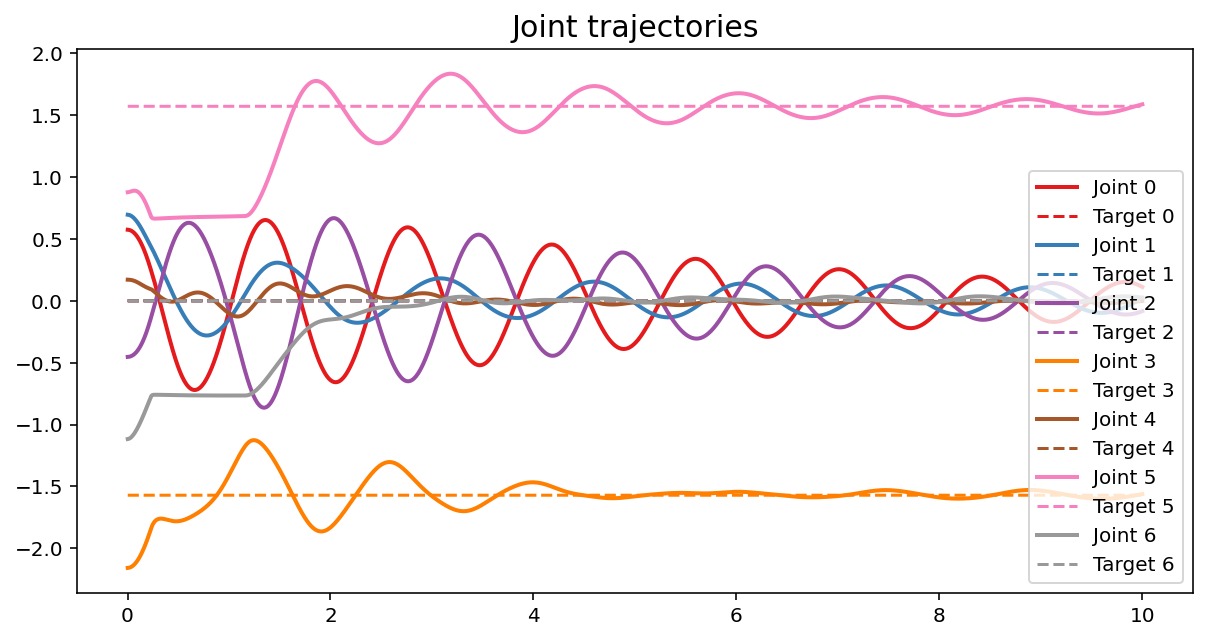

In [4]:
plt.figure(figsize=(10,5))
colors = get_colors(n=env.n_rev_joint,cm=plt.cm.Set1)
for i_idx in range(env.n_rev_joint):
    plt.plot(sec_list[1:],q_list[1:,i_idx],'-',color=colors[i_idx],lw=2,label='Joint %d'%(i_idx))
    plt.plot(sec_list[1:],q_rev_des[i_idx]+0.0*q_list[1:,i_idx],'--',color=colors[i_idx],
             label='Target %d'%(i_idx))
plt.legend(loc='lower right')
plt.title('Joint trajectories',fontsize=15)
plt.show()